In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
# from torch.amp import GradScaler, autocast
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /cim/<username>/ecse626proj/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT

/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

## Checking data and downsizing

In [3]:
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from common.utils import plot_brain_3_views

In [5]:
data_dir = "/cim/ehoney/ecse626proj/preprocessed_data"

(128, 128, 128)


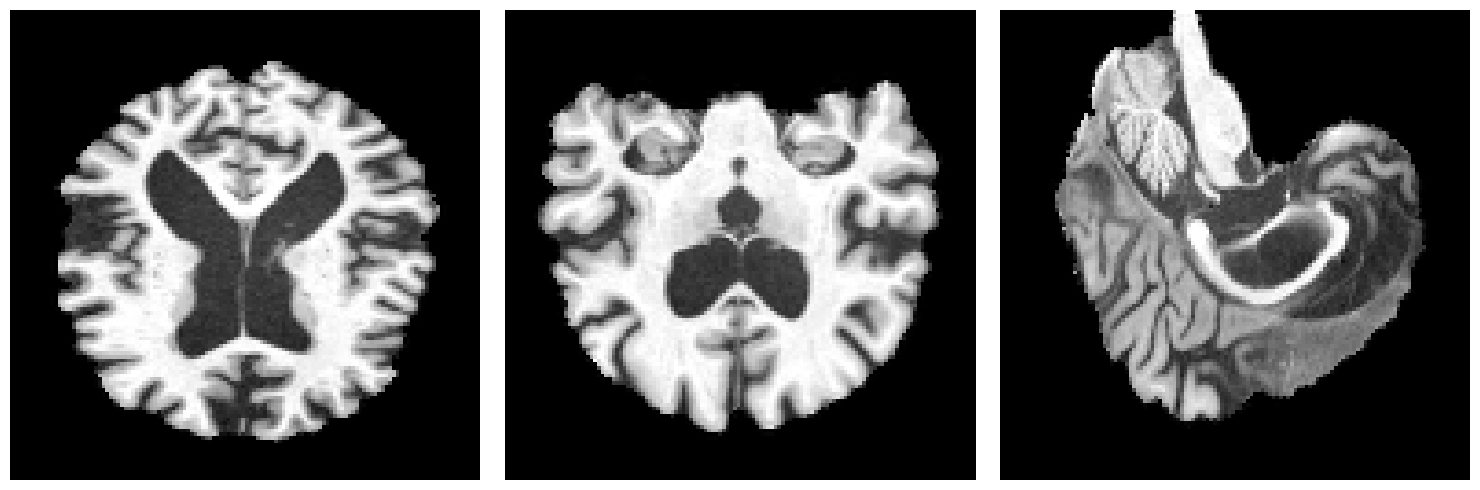

(64, 64, 64)


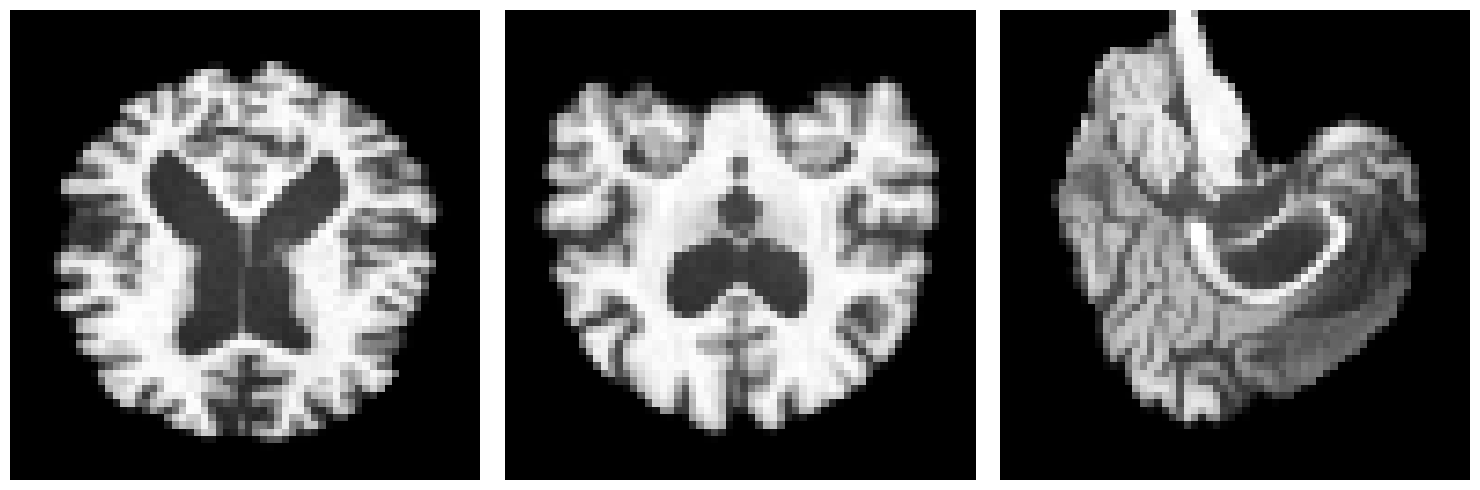

In [6]:
for i, subject in enumerate(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject)
    brain_data = np.load(subject_path)
    print(brain_data.shape)
    plot_brain_3_views(brain_data)

    brain_data = resize(brain_data, (64, 64, 64), order=3, mode='constant', anti_aliasing=True)
    print(brain_data.shape)
    plot_brain_3_views(brain_data)
    
    
    break

Now downsized data saved in `"/cim/ehoney/ecse626proj/preprocessed_data_64"`

## Trying MONAI unconditional model

Check which slices to use

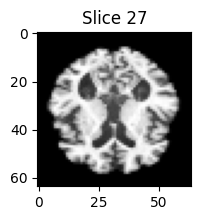

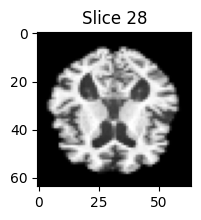

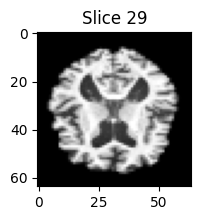

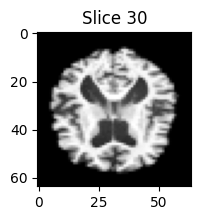

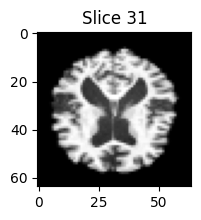

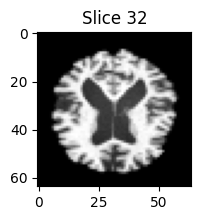

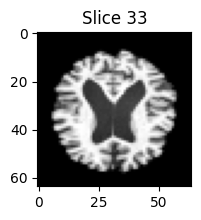

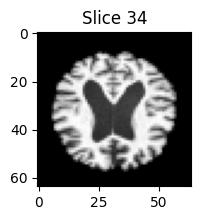

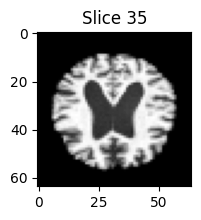

In [7]:
for i in range(27, 36):
    plt.figure(figsize=(2,2))
    plt.imshow(brain_data[i], cmap='gray')
    plt.title(f'Slice {i}')
    plt.show()

In [8]:
from common.dataset import ADNIDataset

In [9]:
batch_size = 4

data_dir = "/cim/ehoney/ecse626proj/preprocessed_data_64"
train_dataset = ADNIDataset(data_dir, sample_full_brain=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) # CHANGE to NUM_WORKERS=4

In [10]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [11]:
random_integer = torch.randint(27, 36, (4,))
random_integer

tensor([35, 34, 30, 29])

100%|██████████| 1000/1000 [00:16<00:00, 61.71it/s]


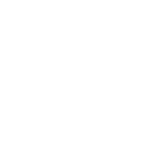

100%|██████████| 1000/1000 [00:15<00:00, 62.92it/s]


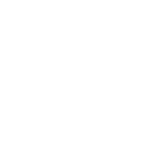

Epoch 11:  50%|████    | 109/216 [00:06<00:05, 18.04it/s, loss=0.0255]


KeyboardInterrupt: 

In [12]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            random_integers = torch.randint(27, 36, (4,))
            images = batch[torch.arange(batch_size), random_integers, :, :].to(device)
            images = images.unsqueeze(1).to(torch.float16)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True, device_type='cuda'):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            # model.eval()
            # val_epoch_loss = 0
            # for step, batch in enumerate(train_loader):
            #     random_integers = torch.randint(27, 36, (4,))
            #     images = batch[torch.arange(batch_size), random_integers, :, :].to(device)
            #     images = images.unsqueeze(1).to(torch.float16)
            #     with torch.no_grad():
            #         with autocast(enabled=True, device_type='cuda'):
            #             noise = torch.randn_like(images).to(device)
            #             timesteps = torch.randint(
            #                 0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            #             ).long()
            #             noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            #             val_loss = F.mse_loss(noise_pred.float(), noise.float())

            #     val_epoch_loss += val_loss.item()
            #     progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            # val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True, device_type='cuda'):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

100%|██████████| 1000/1000 [00:15<00:00, 63.46it/s]


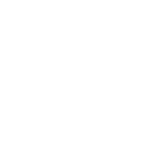

In [13]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True, device_type='cuda'):
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [21]:
torch.isnan(image).all()

tensor(True, device='cuda:0')

Not working for some reason. Let's try their model AND their data.

## MONAI example with their data

In [3]:
directory = "/cim/ehoney/ecse626proj/round2"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/cim/ehoney/ecse626proj/round2


In [4]:
set_determinism(42)

### Download data and set up dataloaders

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

2024-12-01 20:12:31,421 - INFO - Downloaded: /cim/ehoney/ecse626proj/round2/MedNIST.tar.gz
2024-12-01 20:12:31,542 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-01 20:12:31,543 - INFO - Writing into directory: /cim/ehoney/ecse626proj/round2.


In [54]:
batch_size=128
num_workers=8

In [55]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True)

Loading dataset:   0%|          | 0/7999 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 7999/7999 [00:11<00:00, 667.47it/s]


In [56]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

2024-12-01 20:40:20,945 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-01 20:40:20,947 - INFO - File exists: /cim/ehoney/ecse626proj/round2/MedNIST.tar.gz, skipped downloading.
2024-12-01 20:40:20,948 - INFO - Non-empty folder exists in /cim/ehoney/ecse626proj/round2/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 1005/1005 [00:01<00:00, 634.48it/s]


batch shape: torch.Size([128, 1, 64, 64])


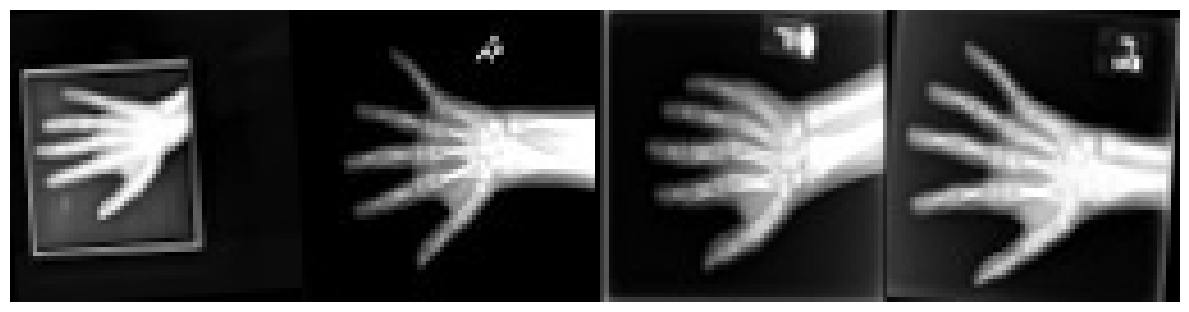

In [57]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Model + training

In [58]:
device = torch.device("cuda:0")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [59]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = torch.nn.DataParallel(model)

model.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connect

/tmp/ipykernel_1798980/1429758565.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                 | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1798980/1429758565.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 0:  46%|█████▌      | 29/63 [00:07<00:09,  3.76it/s, loss=0.885]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76d699da20>
Traceback (most recent call last):
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/li

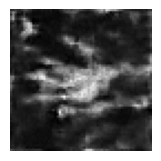

100%|██████████| 1000/1000 [00:31<00:00, 31.95it/s]


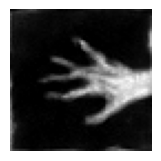

100%|██████████| 1000/1000 [00:36<00:00, 27.09it/s]


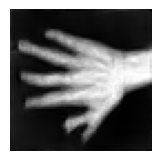

100%|██████████| 1000/1000 [00:34<00:00, 29.08it/s]


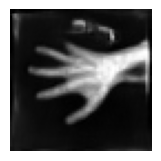

100%|██████████| 1000/1000 [00:35<00:00, 28.08it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76d699da20>
Traceback (most recent call last):
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76d699da20>
Traceback (most recent call last):
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/cim/ehoney/ecse626proj/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py"

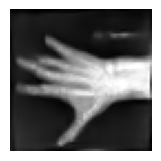

100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s]


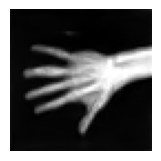

100%|██████████| 1000/1000 [00:26<00:00, 37.89it/s]


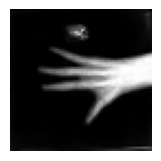

100%|██████████| 1000/1000 [00:26<00:00, 38.31it/s]


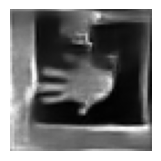

100%|██████████| 1000/1000 [00:32<00:00, 30.36it/s]


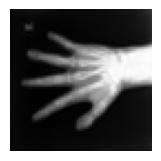

100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]


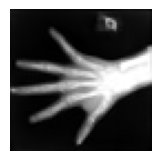

100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]


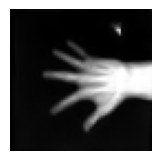

100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


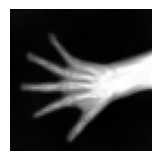

100%|██████████| 1000/1000 [00:26<00:00, 37.20it/s]


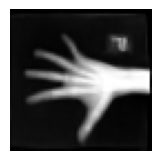

100%|██████████| 1000/1000 [00:31<00:00, 31.77it/s]


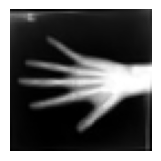

100%|██████████| 1000/1000 [00:26<00:00, 37.11it/s]


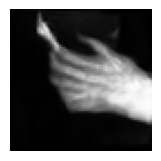

train completed, total time: 1740.7638578414917.


In [60]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

### Learning curves and Markov chain

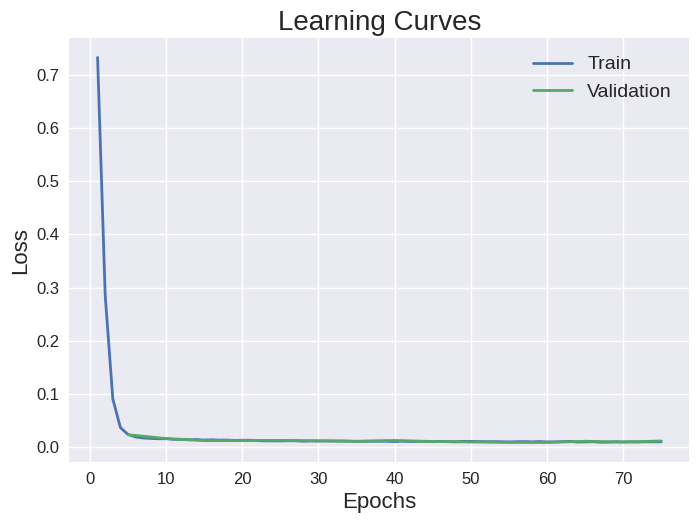

In [61]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

/tmp/ipykernel_1798980/1582947944.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s]


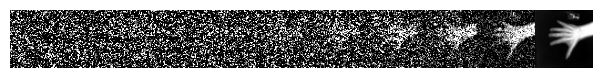

In [62]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

It worked! Now let's analyse training more

In [63]:
device = torch.device("cuda:0")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [64]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = torch.nn.DataParallel(model)

model.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connect

In [68]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)
            
            print(f"images shape: {images.shape}")
            print(f"images range: {images.min(), images.max()}")
            break

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))
        break

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

/tmp/ipykernel_1798980/2246846364.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                 | 0/63 [00:00<?, ?it/s]

images shape: torch.Size([128, 1, 64, 64])


Epoch 0:   0%|                                 | 0/63 [00:01<?, ?it/s]

images range: (metatensor(0., device='cuda:0'), metatensor(1., device='cuda:0'))
train completed, total time: 1.5033068656921387.


## Reattempt

In [14]:
from common.dataset import ADNIDatasetMiddleSlices

In [15]:
batch_size = 128

data_dir = "/cim/ehoney/ecse626proj/preprocessed_data_64"
train_dataset = ADNIDatasetMiddleSlices(data_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) # CHANGE to NUM_WORKERS=4

In [16]:
item = first(train_loader)

In [17]:
item.shape

torch.Size([128, 1, 64, 64])

Correct shape!

In [28]:
device = torch.device("cuda:0")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [29]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = torch.nn.DataParallel(model)

model.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connect

/tmp/ipykernel_1992241/3062332185.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                  | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1992241/3062332185.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
Epoch 4: 100%|███████████████| 7/7 [00:02<00:00,  3.29it/s, loss=0.73]
/tmp/ipykernel_1992241/3062332185.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
100%|██████████| 1000/1000 [00:30<00:00, 32.51it/s]


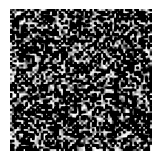

100%|██████████| 1000/1000 [00:32<00:00, 30.74it/s]


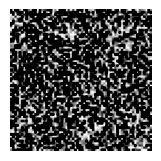

100%|██████████| 1000/1000 [00:31<00:00, 31.25it/s]


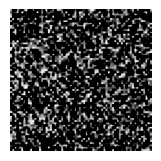

100%|██████████| 1000/1000 [00:27<00:00, 36.30it/s]


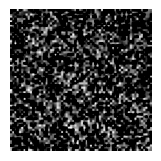

100%|██████████| 1000/1000 [00:27<00:00, 36.24it/s]


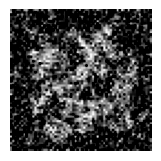

100%|██████████| 1000/1000 [00:27<00:00, 36.68it/s]


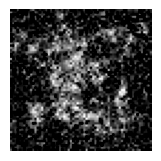

100%|██████████| 1000/1000 [00:30<00:00, 32.84it/s]


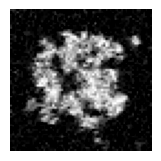

100%|██████████| 1000/1000 [00:30<00:00, 33.07it/s]


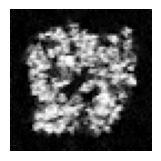

100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s]


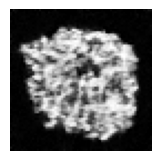

100%|██████████| 1000/1000 [00:28<00:00, 34.55it/s]


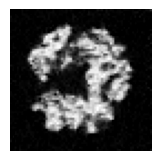

100%|██████████| 1000/1000 [00:29<00:00, 33.70it/s]


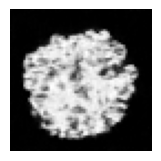

100%|██████████| 1000/1000 [00:32<00:00, 30.73it/s]


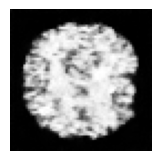

100%|██████████| 1000/1000 [00:31<00:00, 31.35it/s]


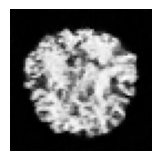

100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]


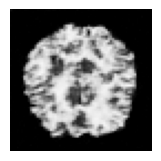

100%|██████████| 1000/1000 [00:23<00:00, 41.86it/s]


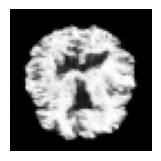

train completed, total time: 674.2651188373566.


In [30]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch.to(device)
            images = images.float()

            # plt.imshow(images[0, 0].cpu(), cmap='gray')
            # plt.show()
            # break
            
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=False):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            # val_epoch_loss = 0
            # for step, batch in enumerate(val_loader):
            #     images = batch["image"].to(device)
            #     with torch.no_grad():
            #         with autocast(enabled=True):
            #             noise = torch.randn_like(images).to(device)
            #             timesteps = torch.randint(
            #                 0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            #             ).long()
            #             noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            #             val_loss = F.mse_loss(noise_pred.float(), noise.float())

            #     val_epoch_loss += val_loss.item()
            #     progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            # val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=False):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

Figured out one potential issue - turn off autocast, it was causing training instability and resulting in all NaN values

Brains are emerging. Problem is dataset is much smaller than MONAI example. So let's run for more epochs total and increase validation interval.

In [31]:
device = torch.device("cuda:0")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = torch.nn.DataParallel(model)

model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

Let's use 4 GPUs!


/tmp/ipykernel_1992241/1799109375.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                  | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1992241/1799109375.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
Epoch 49: 100%|████████████| 7/7 [00:02<00:00,  3.35it/s, loss=0.0292]
/tmp/ipykernel_1992241/1799109375.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
100%|██████████| 1000/1000 [00:22<00:00, 43.78it/s]


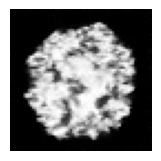

100%|██████████| 1000/1000 [00:22<00:00, 45.08it/s]


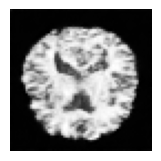

100%|██████████| 1000/1000 [00:26<00:00, 37.25it/s]


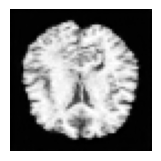

100%|██████████| 1000/1000 [00:24<00:00, 41.13it/s]


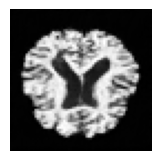

100%|██████████| 1000/1000 [00:23<00:00, 42.64it/s]


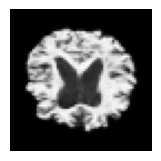

100%|██████████| 1000/1000 [00:23<00:00, 42.66it/s]


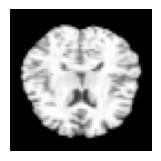

Epoch 303:  71%|███████▊   | 5/7 [00:01<00:00,  3.06it/s, loss=0.0181]


KeyboardInterrupt: 

In [32]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 750
    val_interval = 50
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch.to(device)
            images = images.float()

            # plt.imshow(images[0, 0].cpu(), cmap='gray')
            # plt.show()
            # break
            
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=False):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            # val_epoch_loss = 0
            # for step, batch in enumerate(val_loader):
            #     images = batch["image"].to(device)
            #     with torch.no_grad():
            #         with autocast(enabled=True):
            #             noise = torch.randn_like(images).to(device)
            #             timesteps = torch.randint(
            #                 0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            #             ).long()
            #             noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            #             val_loss = F.mse_loss(noise_pred.float(), noise.float())

            #     val_epoch_loss += val_loss.item()
            #     progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            # val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=False):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

In [33]:
checkpoint = {
        'epoch': epoch,
        'model_sd': model.state_dict(),
        'optim_sd': optimizer.state_dict(),
        'loss': epoch_loss
    }
torch.save(checkpoint, '/cim/ehoney/ecse626proj/round2/ckpt.pth.tar')

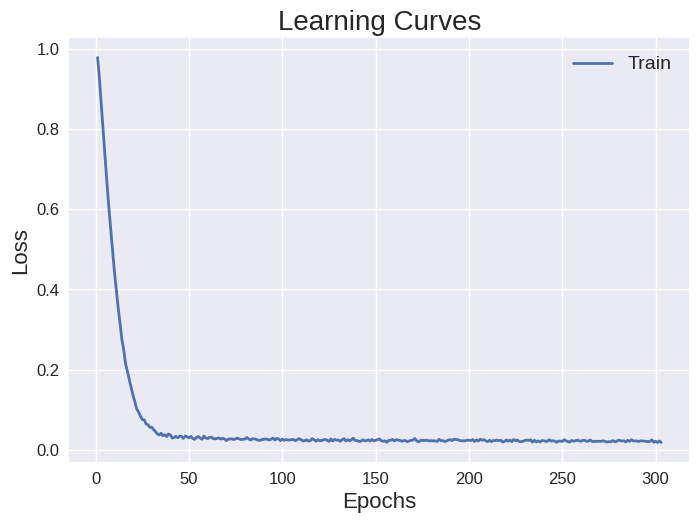

In [35]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, 303, 303), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    # plt.plot(
    #     np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    #     val_epoch_loss_list,
    #     color="C1",
    #     linewidth=2.0,
    #     label="Validation",
    # )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

/tmp/ipykernel_1992241/4013771080.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
100%|██████████| 1000/1000 [00:28<00:00, 35.60it/s]


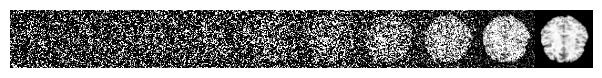

In [36]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=False):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()